# 1. Soft SVM with 2 features and 10 samples

In [1]:

from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.utils import shuffle
data = datasets.load_breast_cancer()
from sklearn.preprocessing import StandardScaler

import jax.numpy as jnp
from jax import grad as fgrad
from jax import jit, vmap, jacfwd, jacrev, device_put
import numpy as np
from numpy.linalg import norm
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import grad
from scipy.integrate import solve_ivp
np.set_printoptions(suppress=True)
from matplotlib import pyplot as plt
import random
import jax

from copy import deepcopy

CUDA = torch.cuda.is_available()
mse = nn.MSELoss(reduction='none')
NUMERICAL_METHOD = 'RK45'

seed = 23

random.seed(seed)
# Set seed for NumPy
np.random.seed(seed)
# Set seed for PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
# Set seed for JAX
key = jax.random.PRNGKey(seed)

In [2]:
def select_n_points(data_X, data_y, n):
    # Check if n is even
    if n % 2 != 0:
        raise ValueError("n must be an even number to select equal points from both classes.")

    # Separate the data into two classes: +1 and -1
    class_pos = data_X[data_y == 1]  # Class +1
    class_neg = data_X[data_y == -1]  # Class -1

    # Check if enough points exist in both classes
    if len(class_pos) < n // 2 or len(class_neg) < n // 2:
        raise ValueError("Not enough data points in one or both classes to select n points.")

    # Randomly select n//2 points from each class
    selected_pos = class_pos[np.random.choice(len(class_pos), n // 2, replace=False)]
    selected_neg = class_neg[np.random.choice(len(class_neg), n // 2, replace=False)]

    # Combine the selected points and their labels
    selected_X = np.vstack((selected_pos, selected_neg))
    selected_y = np.hstack((np.ones(n // 2), -np.ones(n // 2)))

    # Shuffle the selected points and labels
    selected_X, selected_y = shuffle(selected_X, selected_y, random_state=42)

    return selected_X, selected_y

In [3]:
X = data.data 
y = data.target
feature_names = data.feature_names

X = pd.DataFrame(X, columns=feature_names) 
# Select only the desired features
data_X = X[['mean radius', 'mean concave points']].to_numpy()

# Encode y to be +1 and -1
le = LabelEncoder()
data_y = le.fit_transform(y)
data_y[data_y == 0] = -1  # Replace 0 with -1

[Text(0.5, 0, 'mean radius'), Text(0, 0.5, 'mean concave points')]

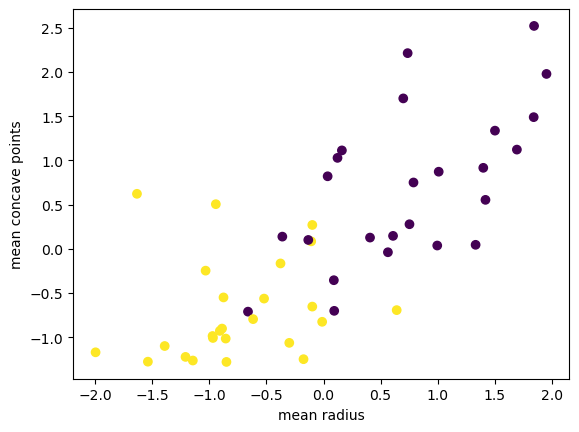

In [4]:
n = 50
selected_X, selected_y = select_n_points(data_X, data_y, n)
scaler = StandardScaler()
selected_X = scaler.fit_transform(selected_X)
_, ax = plt.subplots()
scatter = ax.scatter(selected_X[:, 0], selected_X[:, 1], c=selected_y)
ax.set(xlabel='mean radius', ylabel='mean concave points')

In [5]:
# Define the plotting function
def plot_svm_decision_boundary(X, y, w, b, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Iris versicolor')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Iris setosa')

    # Plot decision boundary
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Use only the selected features for the decision boundary
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = np.dot(grid, w[[feature_x_idx, feature_y_idx]]) + b
    Z = Z.reshape(xx.shape)
    
    plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])
    
    plt.xlabel(f'mean radius')
    plt.ylabel(f'mean concave points')
    plt.legend()
    plt.title('Soft Margin SVM Decision Boundary')
    plt.show()
    
# Define the modified plotting function to plot two decision boundaries
def plot_svm_decision_boundary_confrontation(X, y, w_1, b_1, w_2, b_2, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Iris versicolor')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Iris setosa')

    # Create mesh grid for decision boundaries
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # First model's decision boundary (Ground Truth) in orange with highlight effect (thicker and transparent)
    Z1 = np.dot(grid, w_1[[feature_x_idx, feature_y_idx]]) + b_1
    Z1 = Z1.reshape(xx.shape)
    ground_truth = plt.contour(xx, yy, Z1, colors='purple', levels=[0], alpha=0.3, linewidths=5, linestyles=['-'])
    plt.contour(xx, yy, Z1, colors='purple', levels=[-1, 1], alpha=0.3, linewidths=3, linestyles=['--'])
    
    # Second model's decision boundary (ODE Solution) in purple
    Z2 = np.dot(grid, w_2[[feature_x_idx, feature_y_idx]]) + b_2
    Z2 = Z2.reshape(xx.shape)
    ode_solution = plt.contour(xx, yy, Z2, colors='green', levels=[0], alpha=0.8, linewidths=2, linestyles=['-'])
    plt.contour(xx, yy, Z2, colors='green', levels=[-1, 1], alpha=0.8, linewidths=1.5, linestyles=['--'])
    
    # Add the two main lines to the legend
    h1, _ = ground_truth.legend_elements()
    h2, _ = ode_solution.legend_elements()
    legend_elements = [h1[0], h2[0], 
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10)]
    legend_labels = ['Ground Truth', 'ODE Solution', 'Iris versicolor', 'Iris setosa']
    plt.legend(legend_elements, legend_labels, loc='upper right')
    
    # Add labels, title, and show the plot
    plt.xlabel(f'mean radius')
    plt.ylabel(f'mean concave points')
    plt.title('SVM Decision Boundaries')
    plt.show()

In [6]:
def adjust_label_positions(positions, min_distance=0.02):
    """Adjust vertical positions of labels to avoid overlap."""
    sorted_positions = sorted(enumerate(positions), key=lambda x: x[1])
    adjusted_positions = positions.copy()
    
    for i in range(1, len(sorted_positions)):
        curr_idx, curr_pos = sorted_positions[i]
        prev_idx, prev_pos = sorted_positions[i-1]
        
        if curr_pos - prev_pos < min_distance:
            adjusted_positions[curr_idx] = prev_pos + min_distance
    
    return adjusted_positions

def plot_ode_system(t_values, y_values):
    plt.figure(figsize=(8, 6))
    # Enable LaTeX rendering
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Plot each line and prepare label information
    labels = [f'a_{i}' for i in range(1,nx+1)]
    colors = plt.cm.rainbow(np.linspace(0, 1, len(labels)))
    label_positions = []

    for i, (label, color) in enumerate(zip(labels, colors)):
        line = plt.plot(t_values, y_values[i, :], label=label, color=color)[0]
        label_positions.append(y_values[i, -1])

    # Adjust label positions
    y_min, y_max = np.min(y_values), np.max(y_values)
    y_range = y_max - y_min
    min_distance = 0.02 * y_range  # 2% of y-range as minimum distance
    adjusted_positions = adjust_label_positions(label_positions, min_distance)

    # Add adjusted labels with increased font size and space
    fontsize = 14  # Adjust the font size here
    x_offset = 1  # Space to move the label away from the line
    
    for i, (label, color, position) in enumerate(zip(labels, colors, adjusted_positions)):
        math_label = f"${label}$"  # Add space with LaTeX's \quad
        x_end = t_values[-1]
        plt.text(x_end + x_offset, position, f' {math_label}', verticalalignment='center', 
                 horizontalalignment='left', color=color, fontsize=fontsize)

    plt.xlabel('Time', fontsize=fontsize)
    plt.ylabel('y(t)', fontsize=fontsize)
    plt.title('ODE System Solution', fontsize=fontsize)
    plt.grid(False)

    # Adjust the plot limits to make room for labels
    plt.xlim(t_values[0], t_values[-1] * 1.1)  # Extend x-axis by 10%
    #plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)  # Extend y-axis by 10% on both ends

    plt.tight_layout()
    plt.show()

Matrix G is not PSD, regularizing...
Time: 0.018172264099121094
Optimal objective value: -124.21022244044644
SCS solver iterations: 125
SCS solve time: 0.002189032
SCS setup time: 0.002216052
Weight vector w: [-1.77443775 -1.24262701]
Bias term b: -0.0476383137148895
Optimal value: -124.2102
Number of support vectors: 3
Dual variables (alpha): [ 0.00003982 -0.00006565 -0.00007669 -0.00001398 10.0000736  -0.00000942
 -0.00003181 -0.00001512  3.27968423  0.00006072  0.00002499  0.00003654
 -0.00003567  0.00003955 10.00007889  0.0000075   9.99990967  9.99995067
 -0.00003068  0.00003656  5.3744897   0.00002926 10.00007525 -0.00006327
 -0.00002235  0.00005413 -0.00000547 -0.00003495  9.9999247   7.90305298
 -0.00001988  0.00003929 -0.00007556  0.00006019  0.00002822  0.0000126
  9.99993191 -0.00000619  0.00002064 -0.00004214  0.00003667 10.00006801
  0.00003903  9.99990497 10.00010059  0.00004394  9.99991644  0.00005065
 -0.00004291 -0.0000311 ]
Constraints: [ -0.00003982   0.00006565   0.0

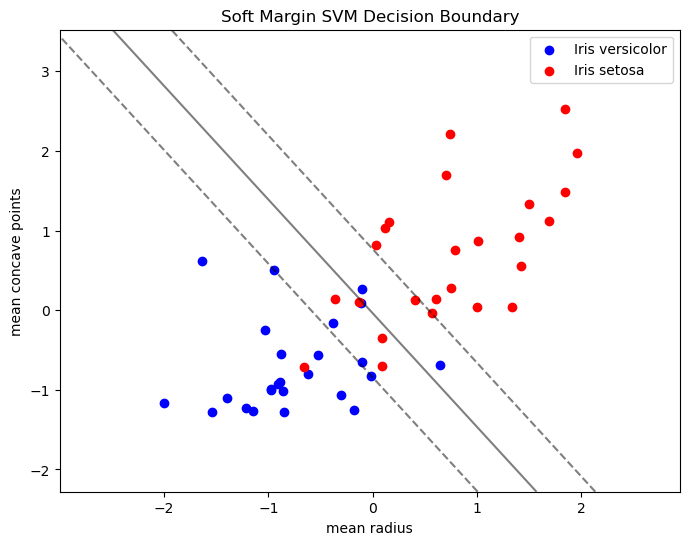

In [7]:
import cvxpy as cp
import numpy as np
import time

C = 10

num_samples = selected_X.shape[0]
num_features = selected_X.shape[1]


# Define the dual variables
alpha = cp.Variable(num_samples)

# Kernel matrix (for linear kernel, it's just dot product of features)
K = selected_X @ selected_X.T

G = np.outer(selected_y, selected_y) * K # G_ij = y_i y_j K(x_i, x_j)

eigvals = np.linalg.eigvals(G)

if np.any(eigvals < 0):
    print("Matrix G is not PSD, regularizing...")
    G += np.eye(num_samples) * 1e-6 
    

objective = cp.Minimize((1/2) * cp.quad_form(alpha, G) - cp.sum(alpha))

# Define the constraints
constraints = [
    selected_y.T @ alpha == 0,
    alpha >= 0,
    alpha <= C
]

problem = cp.Problem(objective, constraints)

t0 = time.time()
problem.solve(solver='SCS')
solve_time = time.time() - t0

# Get solver stats
solver_stats = problem.solver_stats
print('Time:', solve_time)
print('Optimal objective value:', problem.value)
print('SCS solver iterations:', solver_stats.num_iters)
print('SCS solve time:', solver_stats.solve_time)
print('SCS setup time:', solver_stats.setup_time)

def alpha_to_wb(alpha, X, y, epsilon=1e-3):
    w = np.sum(alpha.reshape(-1, 1) * y.reshape(-1, 1) * X, axis=0)

    # Find support vectors (points where 0 < alpha < C)
    support_vector_indices = np.where((alpha > epsilon) & (alpha < C - epsilon))[0]
    n_support_vectors = len(support_vector_indices)
    
    if len(support_vector_indices) == 0:
        raise ValueError("No support vectors found. Try adjusting epsilon.")
    
    # Calculate b using the average over all support vectors
    b = 0
    for i in support_vector_indices:
        b += y[i] - np.dot(w, X[i])
    
    b /= len(support_vector_indices)
    
    return w, b, n_support_vectors
    
w_op, b_op, sv_op = alpha_to_wb(alpha.value, selected_X, selected_y)

print(f"Weight vector w: {w_op}")
print(f"Bias term b: {b_op}")

print(f"Optimal value: {problem.value:.4f}")
print(f"Number of support vectors: {np.sum(sv_op)}")

print('Dual variables (alpha):', alpha.value)

g_1 = jnp.array([-alpha.value[i] for i in range(alpha.value.shape[0])])
g_2 = jnp.array([alpha.value[i] - C for i in range(alpha.value.shape[0])])

g_1 = g_1.reshape(-1, 1)
g_2 = g_2.reshape(-1, 1)
g = jnp.concatenate([g_1, g_2])
g_SCS = g.flatten()
print('Constraints:', g_SCS)
alpha_SCS = alpha.value

# Plotting
plot_svm_decision_boundary(selected_X, selected_y, w_op, b_op, 0, 1)

In [8]:
nx = num_samples
nu = num_samples * 2
nw = num_features
NY = nx + nu


A = jnp.array(selected_y.reshape(-1, 1).T)
b = jnp.zeros(1)

In [9]:
PM = A.T@jnp.linalg.inv(A@A.T)@A

def f(x):
    output = (1/2) * x.T @ G @ x - jnp.sum(x)
    return output

def g(x):    
    g_1 = [- x[i] for i in range(selected_y.shape[0])]
    g_2 = [x[i] - C for i in range(selected_y.shape[0])]
    output = jnp.array(g_1 + g_2)
    return output

def h(x):
    output = jnp.clip(A@x-b, a_min=-1, a_max=1)

    return output

df = fgrad(f) # jacobian of f
dg = jacrev(g) # jacobian of g

def P(xu): # projection mapping
    x, u = xu[:nx].reshape((nx,)), xu[nx:].reshape((nu,))
    x = x - (A.T@jnp.linalg.inv(A@A.T))@((A@x-b).reshape((-1, )))
    u = np.clip(u, a_min=0, a_max=None)
    output = np.concatenate([x, u], axis=0)
    return output

def ODE(t, xu):
    x, u = xu[:nx].reshape((nx, )), xu[nx:].reshape((nu, ))

    dx = df(x) + dg(x).T@jnp.clip(u+g(x), a_min=0)
    dx = -(jnp.identity(nx) - PM)@dx - A.T@h(x)
    du = -u + jnp.clip(u+g(x), a_min=0)
    du = 0.5*du
    dxu = jnp.concatenate([dx, du], axis=0)
    return dxu

ODE = jit(ODE)

def evalutation(xu): # metric OuC(x_pred): check if inisde feasable region and return the objective value
    "return  f(x),    if g(x)<=0, f(x)=np.inf, if g(x)>0 "
    x, u= xu[:nx], xu[nx:]
    if (g(x)<=0.001).all():
        obj = f(x)
        #print('g(x) values:', g(x))
    else:
        obj = np.inf
        #print('g(x) values:', g(x))
    return obj

def constraints_diff(g_ODE, g_SCS):
    return jnp.abs(g_ODE - g_SCS)

In [10]:
def solve_ODE(xuv0, T):
    sol = solve_ivp(ODE, [0., T], xuv0, method=NUMERICAL_METHOD)
    result = P(sol.y[:, -1])
    print("objective:",evalutation(result))
    print("Dual variables (alpha):", result[:nx])
    diff = constraints_diff(result[:nx], alpha_SCS)
    print("max diff:", diff.max(), "mean diff:", diff.mean())
    print("Constraints:",g(result[:nx]))
    
    return sol, result

objective: -124.210396
Dual variables (alpha): [ 0.000003    0.00000054 -0.00000005  0.00000308 10.          0.00000449
  0.00000145  0.00000338  3.27571154  0.00000248  0.00000296  0.00000305
  0.00000149  0.00000246 10.         -0.00000021 10.          9.99999809
  0.0000017   0.00000283  5.37484741  0.00000269 10.00000095  0.00000073
  0.00000241  0.00000166  0.00000532  0.0000006  10.          7.90084696
  0.00000246  0.00000155  0.00000023  0.00000253  0.00000331  0.00000383
 10.          0.0000038   0.00000411  0.00000124  0.00000279 10.00000191
  0.00000269  9.99999905 10.00000095  0.000002    9.99999809  0.00000239
  0.00000133  0.00000171]
max diff: 0.003972691 mean diff: 0.0001731755
Constraints: [ -0.000003    -0.00000054   0.00000005  -0.00000308 -10.
  -0.00000449  -0.00000145  -0.00000338  -3.2757115   -0.00000248
  -0.00000296  -0.00000305  -0.00000149  -0.00000246 -10.
   0.00000021 -10.          -9.999998    -0.0000017   -0.00000283
  -5.3748474   -0.00000269 -10.00000

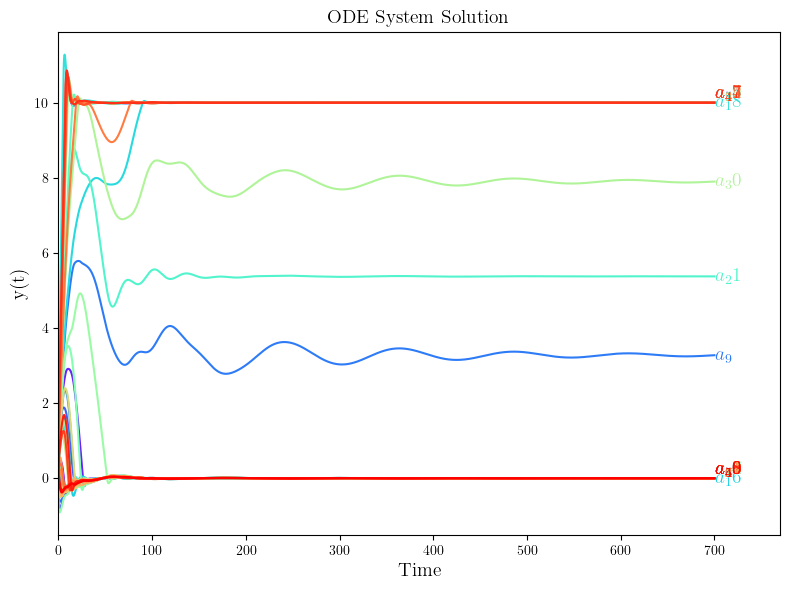

Weight vector w: [-1.77263324 -1.24046676]
Bias term b: -0.04714338368880785
Number of support vectors: 3


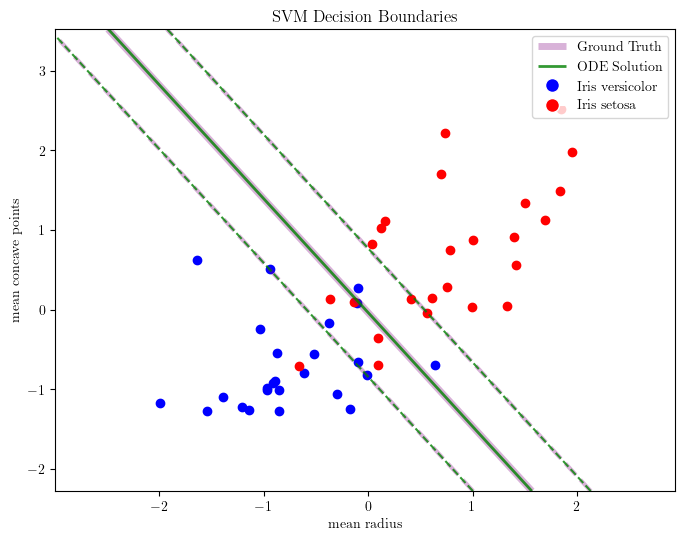

In [13]:
xu0 = jnp.zeros(NY)
xu0 = xu0.at[:nx].set(1.0)

sol, result = solve_ODE(xu0, 700)

t_values = sol.t
y_values = sol.y

plot_ode_system(t_values, y_values)

alpha_ode = result[:nx]
w_ode, b_ode, sv_ode = alpha_to_wb(alpha_ode, selected_X, selected_y)
print(f"Weight vector w: {w_ode}")
print(f"Bias term b: {b_ode}")
print(f"Number of support vectors: {np.sum(sv_ode)}")

plot_svm_decision_boundary_confrontation(selected_X, selected_y, w_op, b_op, w_ode, b_ode, 0, 1)

In [14]:
t0 = time.time()
sol, result = solve_ODE(xu0, 20)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: inf
Dual variables (alpha): [-0.11392762 -0.05434637  1.7220856  -0.08487871  9.98272896 -0.20706007
 -0.08261872 -0.18709928  5.7816081  -0.20100674 -0.16441979 -0.11760607
 -0.09762481 -0.11314309  9.97566891 -0.15164433  6.9076128  10.0906496
 -0.0152889  -0.12336578  8.51908302 -0.14468095  9.99110508 -0.11167607
 -0.16623658  1.56613374 -0.20752341  4.73634481 10.01397991  9.64711475
 -0.1525431  -0.10561499 -0.07593276 -0.23727365 -0.14984126 -0.22217481
 10.04215622 -0.09843877 -0.18158039 -0.07484236 -0.12324104 10.16773891
 -0.11621723 10.00689888 10.03331757 -0.09904396 10.0185318  -0.07869047
 -0.12953041 -0.13480738]
max diff: 4.7363796 mean diff: 0.4651142
Constraints: [  0.11392762   0.05434637  -1.7220856    0.08487871  -9.982729
   0.20706007   0.08261872   0.18709928  -5.781608     0.20100674
   0.16441979   0.11760607   0.09762481   0.11314309  -9.975669
   0.15164433  -6.907613   -10.09065      0.0152889    0.12336578
  -8.519083     0.14468095  -9.991105 

In [15]:
t0 = time.time()
sol, result = solve_ODE(xu0, 50)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: inf
Dual variables (alpha): [ 0.01831706  0.00750765  0.00513782  0.01220175 10.00359154  0.02956231
  0.00215956  0.02625104  4.1306324   0.01035176  0.02559735  0.0192488
  0.013091    0.0183289  10.00442028  0.02222175  7.85420752  9.98536491
  0.00297984  0.01975962  5.27361298  0.02301629 10.00886345  0.01415524
  0.02294443  0.01224344  0.03020872  0.38859901  9.99530697  7.85610867
  0.0212616   0.01770187  0.00975606  0.01127366  0.02369327  0.03373939
  9.99249649  0.01464468  0.02818375  0.00975773  0.01971774  9.09800053
  0.0186647   9.99649239  9.99763584  0.01681257  9.99521828  0.01437405
  0.01720827  0.01833377]
max diff: 2.1457021 mean diff: 0.1019874
Constraints: [ -0.01831706  -0.00750765  -0.00513782  -0.01220175 -10.003592
  -0.02956231  -0.00215956  -0.02625104  -4.1306324   -0.01035176
  -0.02559735  -0.0192488   -0.013091    -0.0183289  -10.00442
  -0.02222175  -7.8542075   -9.985365    -0.00297984  -0.01975962
  -5.273613    -0.02301629 -10.008863  

In [16]:
t0 = time.time()
sol, result = solve_ODE(xu0, 100)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: inf
Dual variables (alpha): [-0.01735035  0.007287    0.00833495 -0.00098576  9.99104786 -0.00499572
  0.00406684 -0.00190633  3.4558785  -0.01803199 -0.01946389 -0.01949629
  0.00330473 -0.01795313  9.98993874 -0.00979444 10.00788212 10.01579094
  0.00349623 -0.01812619  5.5437274  -0.01996233  9.98795795  0.00755704
  0.00053272 -0.01465474 -0.00798541  0.00545615 10.0100174   8.39485645
 -0.00036424 -0.01376686  0.00824209 -0.01718206 -0.01984316 -0.02103203
 10.01022625 -0.00407198 -0.02078608  0.00444091 -0.01800288  9.98561382
 -0.01753903 10.01227093  9.98678398 -0.01525154 10.01430416 -0.01620384
  0.00440051  0.00230479]
max diff: 0.49180347 mean diff: 0.027251203
Constraints: [  0.01735035  -0.007287    -0.00833495   0.00098576  -9.991048
   0.00499572  -0.00406684   0.00190633  -3.4558785    0.01803199
   0.01946389   0.01949629  -0.00330473   0.01795313  -9.989939
   0.00979444 -10.007882   -10.015791    -0.00349623   0.01812619
  -5.5437274    0.01996233  -9.987

In [17]:
t0 = time.time()
sol, result = solve_ODE(xu0, 500)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: inf
Dual variables (alpha): [-0.00070997 -0.00058766 -0.00045976 -0.00128856 10.00022221 -0.00196183
 -0.00070192 -0.00166586  3.34881854 -0.0005828  -0.00102324 -0.00088524
 -0.00099855 -0.00075344 10.00012398 -0.00025061  9.9996357  10.00051594
 -0.00076122 -0.00079753  5.37845659 -0.00100198  9.9998827  -0.00071527
 -0.00141638 -0.00038079 -0.00219222 -0.00055927  9.99987888  7.96405125
 -0.00144391 -0.00043746 -0.00056838 -0.00054197 -0.00100853 -0.00131612
  9.99995613 -0.00156521 -0.00117601 -0.00084301 -0.00078766  9.99975204
 -0.00073095 10.00001526 10.00004578 -0.00052487 10.00019073 -0.00053983
 -0.00101033 -0.0011867 ]
max diff: 0.06913431 mean diff: 0.0033912575
Constraints: [  0.00070997   0.00058766   0.00045976   0.00128856 -10.000222
   0.00196183   0.00070192   0.00166586  -3.3488185    0.0005828
   0.00102324   0.00088524   0.00099855   0.00075344 -10.000124
   0.00025061  -9.999636   -10.000516     0.00076122   0.00079753
  -5.3784566    0.00100198  -9.999

In [18]:
t0 = time.time()
sol, result = solve_ODE(xu0, 1000)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: -124.21287
Dual variables (alpha): [-0.00001813 -0.00001478 -0.00001172 -0.00003374 10.00000572 -0.0000502
 -0.00001759 -0.00004181  3.28100324 -0.00001471 -0.00002556 -0.00002245
 -0.00002517 -0.00001905 10.00000286 -0.0000057   9.99999046 10.00001335
 -0.00001927 -0.00002019  5.37508535 -0.00002496  9.99999714 -0.00001774
 -0.0000349  -0.00000981 -0.00005533 -0.00001416  9.99999714  7.90575933
 -0.00003694 -0.0000112  -0.0000143  -0.00001373 -0.00002517 -0.0000333
  9.99999905 -0.00003962 -0.00002901 -0.00002122 -0.00002043  9.99999332
 -0.00001852 10.00000095 10.00000095 -0.00001354 10.00000477 -0.00001396
 -0.00002561 -0.00003004]
max diff: 0.0027063512 mean diff: 0.00014006876
Constraints: [  0.00001813   0.00001478   0.00001172   0.00003374 -10.000006
   0.0000502    0.00001759   0.00004181  -3.2810032    0.00001471
   0.00002556   0.00002245   0.00002517   0.00001905 -10.000003
   0.0000057   -9.99999    -10.000013     0.00001927   0.00002019
  -5.3750854    0.0000249

In [ ]:
alpha_ode = result[:nx]
w_ode, b_ode, sv_ode = alpha_to_wb(alpha_ode, selected_X, selected_y)

# 3. The method

In [19]:
T=700.0

In [20]:
class FNN(nn.Module):
    def __init__(self, y0):
        self.y0 = torch.tensor(y0, dtype=torch.float)
        if CUDA:
            self.y0 = self.y0.cuda()
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(1, NEURONS).cuda()
        self.linearL = []
        for _ in range(LAYERS-1):
            self.linearL.append(nn.Linear(NEURONS, NEURONS).cuda())
        self.linear2 = nn.Linear(NEURONS, NY).cuda()

    def forward(self, x):
        t = x.cuda()
        x = torch.tanh(self.linear1(x))
        for i in range(LAYERS-1):
            x = torch.tanh(self.linearL[i](x))
        x = self.linear2(x)
        x = self.y0 + (1 - torch.exp(-(t-0)))*x
        return x


class NN_NOP:
    def __init__(self, y0, time_range, P, ODE, C_epsilon): # P: projection mapping, ODE, C_epsilon: OuC metric
        self.y0 = np.array(y0)
        self.time_range = time_range # [0, 10]
        self.T = time_range[-1] # T=10
        self.P = P
        self.ODE = ODE
        self.C_epsilon = C_epsilon
        self.vODE = vmap(ODE, in_axes=(0, 0), out_axes=0)
        #self.numerical_method() # solve analyicallly the ODE

    def numerical_method(self):
        sol = solve_ivp(self.ODE, self.time_range, self.y0, method=NUMERICAL_METHOD)
        self.y_T_ODE = sol.y[:, -1] # get last value of the solution
        self.y_T_ODE = self.P(self.y_T_ODE) # project it
        self.y_T_ODE = np.array(self.y_T_ODE)
        self.epsilon_ODE = self.C_epsilon(self.y_T_ODE) # calculate OuC (f(x))

    def NN_method(self, weights=None, t_L=None):
        """
        train the nn, store the following four

        L_loss:  list, loss of batch during training
        L_epsilon: list, epsilon_best during training
        L_y_T: list, yT during training
        net_best:  the best neural network model during training
        """
        net = FNN(self.y0)
        if weights is not None:
            net.load_state_dict(weights.state_dict())
        if CUDA:
            net = net.cuda()
            
        optimizer = Adam(net.parameters(), lr=LR) # ========> 0.001 not looks good
        i = 0
        L_loss = []
        L_epsilon = []
        L_epsilon_curr = []
        L_y_T = []
        L_y_T_curr = []
        #L_y_iterations = []
        t0 = time.time()
        while True:
            # Update, L_epsilon, L_yT, net_best
            T = self.T*torch.ones((1, 1), dtype=torch.float)
            if CUDA:
                T = T.cuda()
            y_T = self.P_multiple(T, net) # get the output of the nn at T (last time)
            L_y_T_curr.append(y_T)

            epsilon_current = self.C_epsilon(y_T) # calculate OuC (f(x))
            L_epsilon_curr.append(epsilon_current)
            if i==0: # if first iteration
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
                #L_y_iterations.append(self.y_iteration(net_best))
            # if i==10:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==20:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==ITERATIONS-1:
            #L_y_iterations.append(self.y_iteration(net_best)) # store the output of the best nn across the time
            if epsilon_current < epsilon_best:
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
            L_epsilon.append(epsilon_best) # store the best OuC
            L_y_T.append(y_T_best) # store the best output of the nn at T

            # TRAIN MODEL
            # Prepare input t, torch.tensor (NBATCH, 1)
            if t_L is not None:
                t = t_L[i]
            else:
                t = np.random.uniform(0, self.T, (NBATCH, 1))
            t = torch.tensor(t, dtype=torch.float, requires_grad=True)
            if CUDA:
                t = t.cuda()
            # Learning, L_loss
            loss = self.loss_compute(t, net)
            loss.backward()
            L_loss.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()
            # Monitor
            if i%100==0:
            # if i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                #print(f'T: {self.T}, y_T_ODE: {self.y_T_ODE.round(4)}, epsilon_ODE: {self.epsilon_ODE :.4f},  Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}, ||y_T_ODE-y_T_best||_2: {y_T_error :.4f}')
                #print(f'T: {self.T}, Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}')
                pass
            i = i+1
            
            torch.cuda.empty_cache()
            
            if i==ITERATIONS:
                break

        return L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time.time()-t0

    def loss_compute(self, t, net):
        # nn output xu, torch.tensor (NBATCH, nxu)
        y = net(t)

        # => Get ODE derivatives
        # True dxu, torch.tensor (NBATCH, nxu)
        t_cpu = t.cpu().detach().numpy()
        y_cpu = y[:, :].cpu().detach().numpy()
        dy = self.vODE(t_cpu, y_cpu)
        dy = np.array(dy)
        
        dy = torch.tensor(dy, dtype=torch.float)
        if CUDA:
            dy = dy.cuda()

        # => Get NN derivatives (autograd)
        # Predicted pdxu, torch.tensor (NBATCH, nxu)
        pdy = []
        for j in range(NY): # for all outputs node (for all variables)
            # y[:, [j]]: outputs of the nn for the j-th variable (all t of the batch), t: inputs of the nn, grad_outputs: scale the gradients to facilitate the compuation of the jacobian, Craete_graph: to compute higer order derivatives
            pdyi = grad(y[:, [j]], t, grad_outputs=torch.ones_like(y[:, [j]]), create_graph=True)[0] # torch autograd shape [NBATCH, 1]
            pdy.append(pdyi)
        pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]
        #pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]

        # Compute loss, torch.tensor a float
        dynamics_loss = mse(dy, pdy) # [NBATCH, NY]
        dynamics_loss = torch.sum(dynamics_loss, axis=1) # [NBATCH]
        dynamics_loss = torch.exp(-WEIGTHING*(t / T).detach().reshape((-1, )))*dynamics_loss  # proprity smaller t
        dynamics_loss = torch.mean(dynamics_loss, axis=0)
        
        return dynamics_loss

    def P_multiple(self, t, net): # get the projection of the output of the nn (for multiple t)
        y = net(t)
        y = y.reshape((-1, )).cpu().detach().numpy()
        output = self.P(y)
        output = np.array(output)
        return output

    def y_iteration(self, net): # get the ODE system estiamtion across the time
        # For L_y
        t = torch.arange(0, self.T, 0.1).reshape((-1, 1))
        if CUDA:
            t = t.cuda()
        y = [self.P_multiple(t[i].reshape((1,1)), net) for i in range(t.shape[0])]
        y = torch.tensor(np.array(y)).cpu().detach().numpy()

        return y # [T, NY]


In [21]:
y0 = np.zeros(NY)
y0[:nx] = 1.0

In [22]:
def try_layers(l_list, n, lr):
     NEURONS = n
     LR = lr
     res = []
     for l in l_list:
          LAYERS = l
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time})
     return res

def try_neurons(n_list, l, lr):
     LAYERS = l
     LR = lr
     res = []
     for n in n_list:
          NEURONS = n
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time})
     return res

def try_lr(lr_list, l, n):
     LAYERS = l
     NEURONS = n
     res = []
     for lr in lr_list:
          LR = lr
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time})
     return res

def plot_results(res, y_max=50):
    fig, axes = plt.subplots(1, len(res), figsize=(20, 6))
    y_min = 0
    for i in range(len(res)):
        # Plot on the first subplot
        axes[i].plot(res[i]['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
        axes[i].plot(res[i]['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
        axes[i].set_xlabel('iteration')
        axes[i].set_ylabel('OuC metric')
        axes[i].set_title(f'l={res[i]["layers"]}, n={res[i]["neurons"]}, lr={res[i]["lr"]}')
        axes[i].legend()
        axes[i].grid(True)
        axes[i].set_ylim(y_min, y_max)
        axes[i].set_xlim(0, ITERATIONS)
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    # Show the plot
    plt.show()

def plot_result_confrontation(res):
     plt.figure(figsize=(6, 5))
     for r in res:
          plt.plot(r['L_epsilon'], marker='o', linestyle='-', label=f'l={r["layers"]}, n={r["neurons"]}, lr={r["lr"]}', markersize=1)
     # Add labels, title, legend and grid
     plt.xlabel('iteration')
     plt.ylabel('OuC metric')
     plt.title('Numbers of layers')
     plt.legend()  # Show the legend to distinguish the datasets
     plt.grid(False)
     plt.show()

def plot_hyperplane(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]]).cuda()).cpu().detach().numpy()
     w_net = epsilon[0][:selected_X.shape[1]]
     b_net = epsilon[0][selected_X.shape[1]]
     # Plotting
     plt.figure(figsize=(10, 8))
     plt.scatter(selected_X[selected_y > 0][:, 0], selected_X[selected_y > 0][:, 1], c='b', label='Class 1')
     plt.scatter(selected_X[selected_y < 0][:, 0], selected_X[selected_y < 0][:, 1], c='r', label='Class -1')

     # Plot the decision boundary
     x_min, x_max = selected_X[:, 0].min() - 1, selected_X[:, 0].max() + 1
     y_min, y_max = selected_X[:, 1].min() - 1, selected_X[:, 1].max() + 1
     xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
     Z = np.dot(np.c_[xx.ravel(), yy.ravel()], w_net) + b_net
     Z = Z.reshape(xx.shape)
     plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])

     # Plot the margins
     plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])

     plt.xlabel('Feature 1')
     plt.ylabel('Feature 2')
     plt.legend()
     plt.title('Hard Margin SVM Decision Boundary')
     plt.show()

def get_error(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]], dtype=torch.float32).cuda()).cpu().detach().numpy()
     # Split epsilon into weights and bias
     alpha_net = epsilon[0][:nx]  # All weights

     # Calculate absolute differences for weights and bias
     alpha_abs_diff = np.abs(alpha_ode - alpha_net)

     # Calculate squared differences
     alpha_sq_diff = alpha_abs_diff ** 2               # Vector for squared differences of weights           # Squared difference for bias

     # Calculate the Mean Squared Error (MSE)
     mse_ = np.mean(alpha_sq_diff)

     return mse_

LAYERS: 1 NEURONS: 100 LR: 0.01 epsilon: 452.8319 MSE solution: 15.155566408599771 time: 379.1136713027954
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 412.28903 MSE solution: 13.437280472532139 time: 384.43192291259766
LAYERS: 3 NEURONS: 100 LR: 0.01 epsilon: 448.1836 MSE solution: 13.072959372835083 time: 381.2978239059448
LAYERS: 4 NEURONS: 100 LR: 0.01 epsilon: 354.59702 MSE solution: 13.984159939680094 time: 389.1190140247345
LAYERS: 5 NEURONS: 100 LR: 0.01 epsilon: 368.1665 MSE solution: 13.048676963629003 time: 380.7595920562744


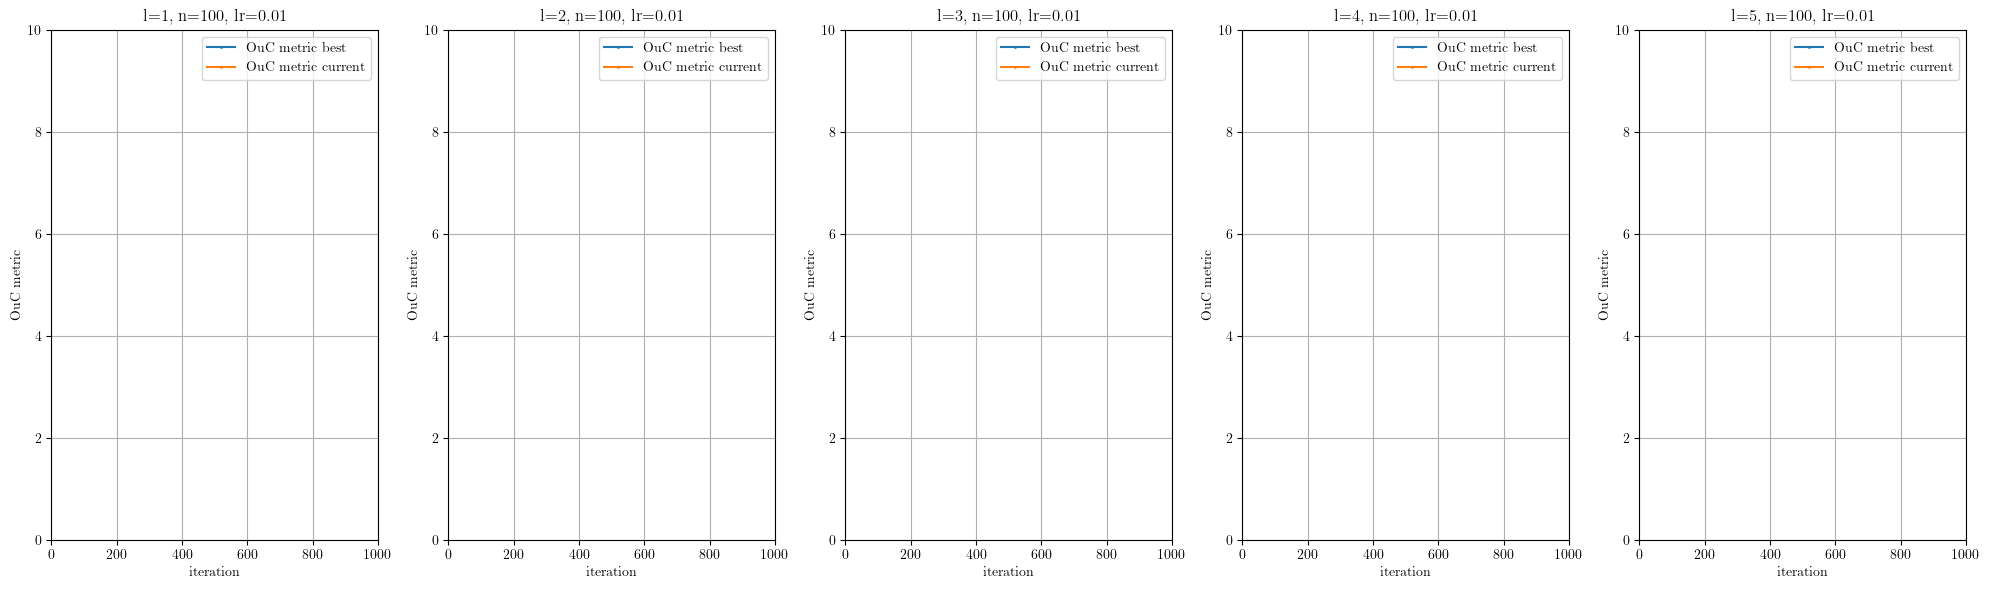

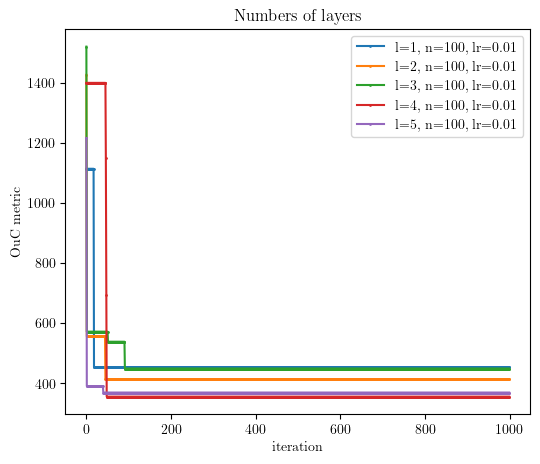

In [25]:
T=700.0
NBATCH = 512
ITERATIONS = 1000
WEIGTHING = 3
NEURONS=100
LR=0.01
LAYERS=2
res_layers = try_layers([1, 2, 3, 4, 5], 100, 0.01)
plot_results(res_layers, y_max=10)
plot_result_confrontation(res_layers)

LAYERS: 2 NEURONS: 50 LR: 0.01 epsilon: 836.44836 MSE solution: 15.164429517887063 time: 373.14780497550964
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 284.08466 MSE solution: 11.529551671051623 time: 370.0400183200836
LAYERS: 2 NEURONS: 200 LR: 0.01 epsilon: 308.59662 MSE solution: 19.40359366022502 time: 371.34806752204895
LAYERS: 2 NEURONS: 300 LR: 0.01 epsilon: 325.17767 MSE solution: 12.951832472229869 time: 371.1975476741791
LAYERS: 2 NEURONS: 400 LR: 0.01 epsilon: 271.07135 MSE solution: 13.55031452342967 time: 371.8166079521179


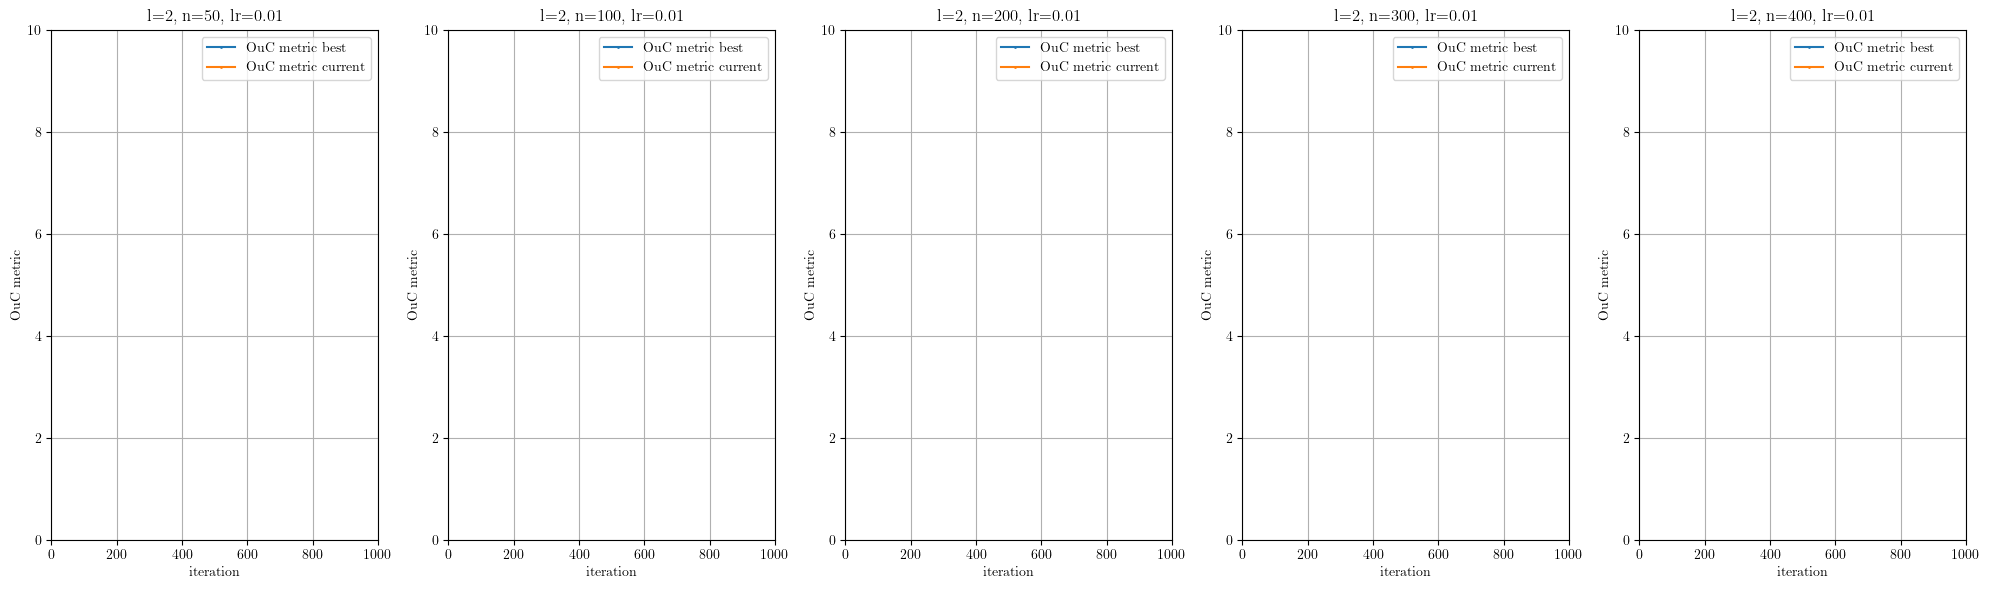

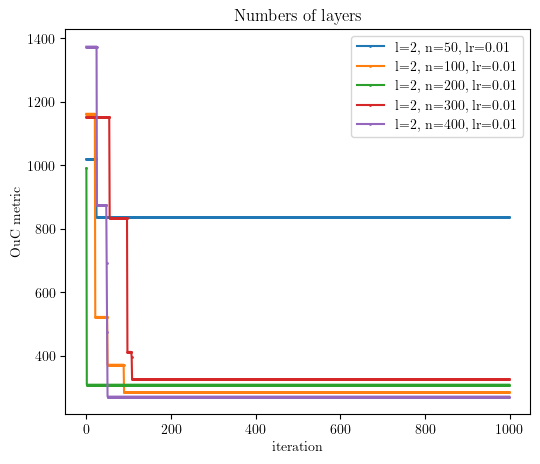

In [26]:
res_neurons = try_neurons([50, 100, 200, 300, 400], 2, 0.01)
plot_results(res_neurons, y_max=10)
plot_result_confrontation(res_neurons)

LAYERS: 2 NEURONS: 100 LR: 0.0001 epsilon: 612.00757 MSE solution: 12.393178019684292 time: 378.88234972953796
LAYERS: 2 NEURONS: 100 LR: 0.001 epsilon: 409.4349 MSE solution: 19.57087188384761 time: 378.3062791824341
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 593.67896 MSE solution: 14.389931596968237 time: 399.9280774593353
LAYERS: 2 NEURONS: 100 LR: 0.1 epsilon: 163.07095 MSE solution: 13.322592552986697 time: 427.70446610450745


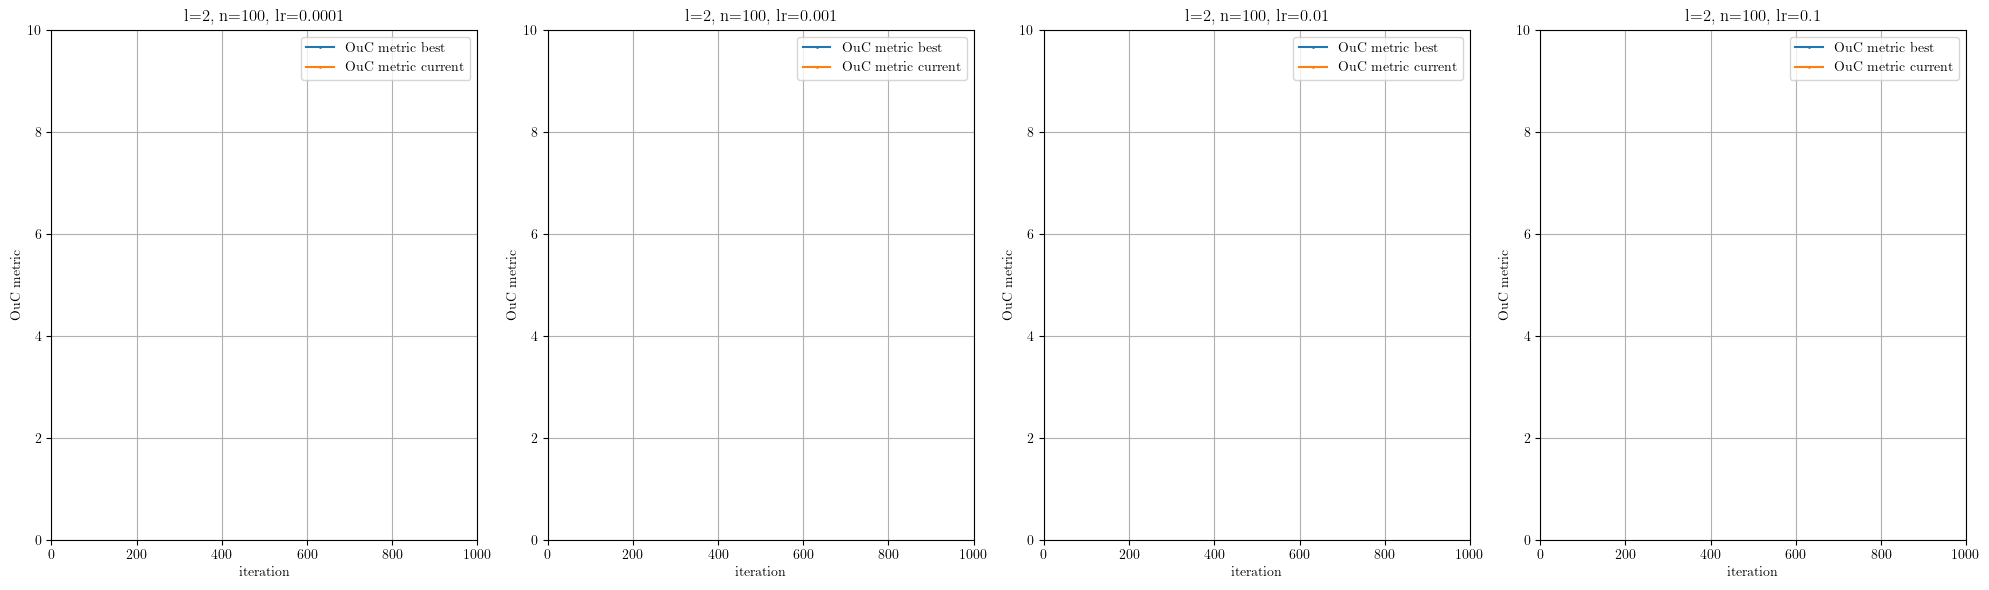

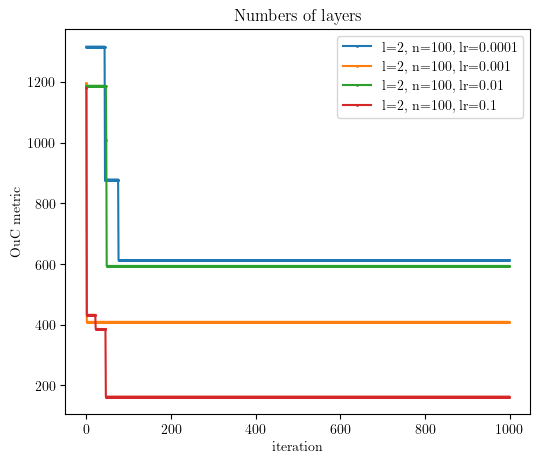

In [27]:
res_learning_rate = try_lr([0.0001, 0.001, 0.01, 0.1], 2, 100)
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

Weight vector w: [-22.39279128 -17.8388842 ]
Bias term b: 3.2400748750660566e-14
Number of support vectors: 50


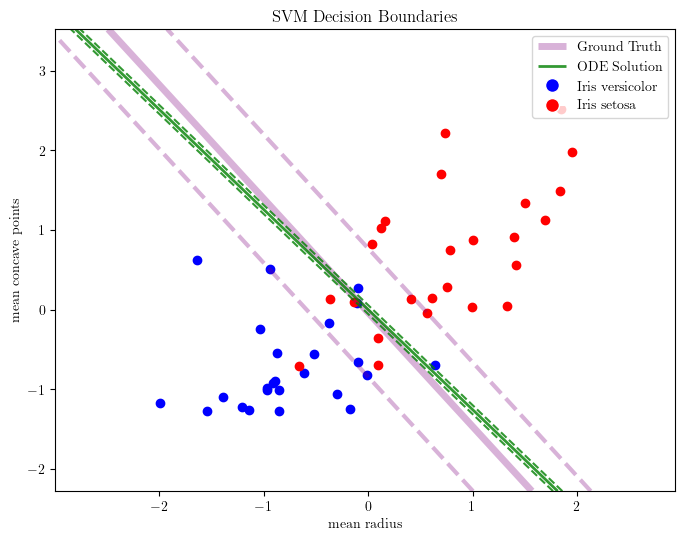

Variables: [0.5917379  1.2163657  1.0463374  0.5620458  3.645421   0.63142055
 0.15088677 0.33929926 1.194242   0.40896565 0.65129566 0.613961
 0.2711537  0.71908575 4.924435   0.38026327 1.4411075  2.0245976
 0.50974464 0.5825753  2.1940262  0.30809903 1.5817428  0.6402394
 0.85909045 1.004626   0.24427879 0.84022564 4.236565   1.1253908
 0.35685205 0.79977167 0.8077078  0.59007764 0.8649652  0.18585563
 1.7247092  0.3820879  0.49262315 0.60645336 0.8269515  1.2409266
 0.8209577  2.2470832  2.8747609  1.0450642  2.3298752  1.2415609
 0.21540701 0.6415887 ]
Constraints: [-0.5917379  -1.2163657  -1.0463374  -0.5620458  -3.645421   -0.63142055
 -0.15088677 -0.33929926 -1.194242   -0.40896565 -0.65129566 -0.613961
 -0.2711537  -0.71908575 -4.924435   -0.38026327 -1.4411075  -2.0245976
 -0.50974464 -0.5825753  -2.1940262  -0.30809903 -1.5817428  -0.6402394
 -0.85909045 -1.004626   -0.24427879 -0.84022564 -4.236565   -1.1253908
 -0.35685205 -0.79977167 -0.8077078  -0.59007764 -0.8649652  -0

In [28]:
net = res_layers[3]['net']
res = net(torch.tensor([T]).cuda()).cpu().detach().numpy()

w_pinn, b_pinn, sv_pinn = alpha_to_wb(res[:nx], selected_X, selected_y)

print(f"Weight vector w: {w_pinn}")
print(f"Bias term b: {b_pinn}")
print(f"Number of support vectors: {np.sum(sv_pinn)}")

plot_svm_decision_boundary_confrontation(selected_X, selected_y, w_ode, b_ode, w_pinn, b_pinn, 0, 1)
print('Variables:', res[:nx])
print('Constraints:', g(res[:nx]))

Weight vector w: [-19.82488444 -16.10929026]
Bias term b: 2.7995383788947947e-14
Number of support vectors: 50


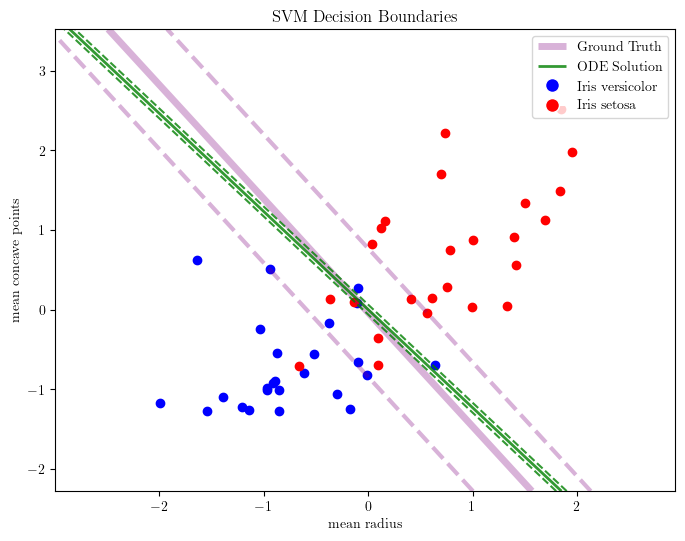

Variables: [0.5304936  1.1405511  0.84910697 0.666939   3.6255336  0.7991766
 0.8106669  0.21500945 1.452809   0.52968633 0.32101035 0.6825249
 0.17626244 0.7061993  3.6385887  0.9860053  1.1976975  2.2407537
 0.3343714  0.6054899  1.9875011  0.53759336 1.727492   0.8932817
 0.2527306  0.9738228  0.15711135 0.92927355 5.3783894  1.1399336
 0.20627499 0.58547527 0.6278541  0.42036617 0.48121202 0.43209875
 2.8850632  0.18198323 0.6689048  0.9633843  1.1314806  1.2983973
 0.353957   2.69409    2.9335487  0.7194449  2.0216038  0.5651603
 0.4153692  0.1246857 ]
Constraints: [-0.5304936  -1.1405511  -0.84910697 -0.666939   -3.6255336  -0.7991766
 -0.8106669  -0.21500945 -1.452809   -0.52968633 -0.32101035 -0.6825249
 -0.17626244 -0.7061993  -3.6385887  -0.9860053  -1.1976975  -2.2407537
 -0.3343714  -0.6054899  -1.9875011  -0.53759336 -1.727492   -0.8932817
 -0.2527306  -0.9738228  -0.15711135 -0.92927355 -5.3783894  -1.1399336
 -0.20627499 -0.58547527 -0.6278541  -0.42036617 -0.48121202 -0

In [29]:
net = res_neurons[4]['net']
res = net(torch.tensor([T]).cuda()).cpu().detach().numpy()

w_pinn, b_pinn, sv_pinn = alpha_to_wb(res[:nx], selected_X, selected_y)

print(f"Weight vector w: {w_pinn}")
print(f"Bias term b: {b_pinn}")
print(f"Number of support vectors: {np.sum(sv_pinn)}")

plot_svm_decision_boundary_confrontation(selected_X, selected_y, w_ode, b_ode, w_pinn, b_pinn, 0, 1)
print('Variables:', res[:nx])
print('Constraints:', g(res[:nx]))

Weight vector w: [-16.80207295 -12.2242245 ]
Bias term b: 2.3732127374387345e-14
Number of support vectors: 50


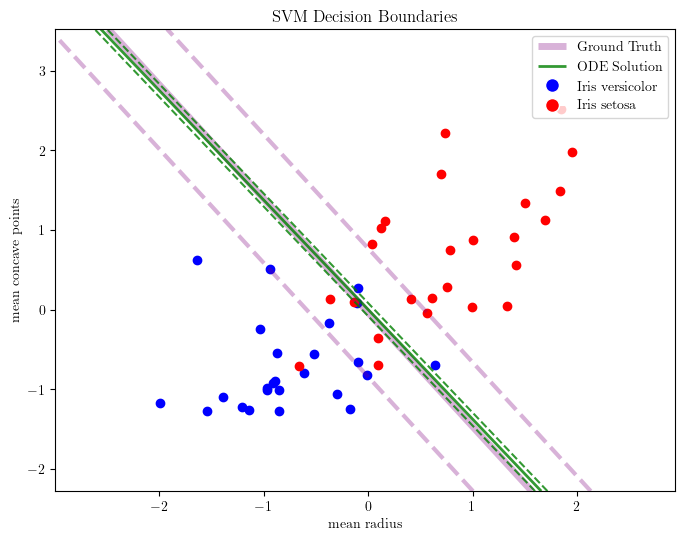

Variables: [0.5792183  0.6981462  0.6214981  0.3010252  4.1350164  0.07047498
 0.51083374 0.38569868 1.4378147  0.7324311  0.45312667 0.5286162
 0.4056961  0.36527693 4.9375105  1.0672697  1.3462908  2.0691352
 0.5925822  0.56376606 2.1278212  0.41164726 1.7030087  0.40290064
 0.02608699 0.84469986 0.14492351 0.7481498  4.5748425  1.2385839
 0.42823476 0.7232294  0.8829816  0.57874215 0.39673066 0.165972
 2.1123571  0.1769793  0.20251119 0.9362222  0.488701   1.3168015
 0.78302544 2.5482848  2.9855971  0.43467015 2.3629293  0.6321459
 0.3965875  0.22296125]
Constraints: [-0.5792183  -0.6981462  -0.6214981  -0.3010252  -4.1350164  -0.07047498
 -0.51083374 -0.38569868 -1.4378147  -0.7324311  -0.45312667 -0.5286162
 -0.4056961  -0.36527693 -4.9375105  -1.0672697  -1.3462908  -2.0691352
 -0.5925822  -0.56376606 -2.1278212  -0.41164726 -1.7030087  -0.40290064
 -0.02608699 -0.84469986 -0.14492351 -0.7481498  -4.5748425  -1.2385839
 -0.42823476 -0.7232294  -0.8829816  -0.57874215 -0.39673066 

In [30]:
net = res_learning_rate[3]['net']
res = net(torch.tensor([T]).cuda()).cpu().detach().numpy()

w_pinn, b_pinn, sv_pinn = alpha_to_wb(res[:nx], selected_X, selected_y)

print(f"Weight vector w: {w_pinn}")
print(f"Bias term b: {b_pinn}")
print(f"Number of support vectors: {np.sum(sv_pinn)}")

plot_svm_decision_boundary_confrontation(selected_X, selected_y, w_ode, b_ode, w_pinn, b_pinn, 0, 1)
print('Variables:', res[:nx])
print('Constraints:', g(res[:nx]))

In [31]:
LAYERS = 2
NEURONS = 100
LR = 0.01
import time
example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, t = example.NN_method() # train
mse_ = get_error({'net': net_best})
print('LAYERS:', LAYERS, 'NEURONS:', NEURONS, 'LR:', LR, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', t)
res = {'layers': LAYERS, 'neurons': NEURONS, 'lr': LR, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time}

LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 385.46707 MSE solution: 11.729982203295368 time: 421.9188849925995


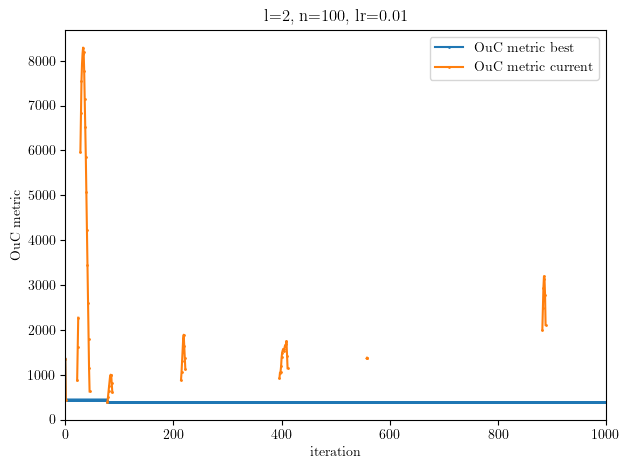

In [32]:
plt.plot(res['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
plt.plot(res['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
plt.xlabel('iteration')
plt.ylabel('OuC metric')
plt.title(f'l={res["layers"]}, n={res["neurons"]}, lr={res["lr"]}')
plt.legend()
plt.grid(False)
#plt.set_ylim(y_min, y_max)
plt.xlim(0, ITERATIONS)

plt.tight_layout()
# Show the plot
plt.show()

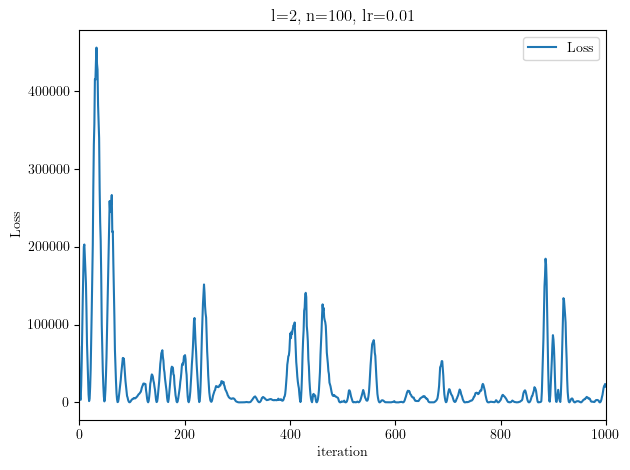

In [33]:
plt.plot(L_loss, label='Loss')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.title(f'l={res["layers"]}, n={res["neurons"]}, lr={res["lr"]}')
plt.legend()
plt.grid(False)
#plt.set_ylim(y_min, y_max)
plt.xlim(0, ITERATIONS)
plt.tight_layout()
# Show the plot
plt.show()

Weight vector w: [-21.00380054 -21.58225186]
Bias term b: -1.6879320494022398
Number of support vectors: 49


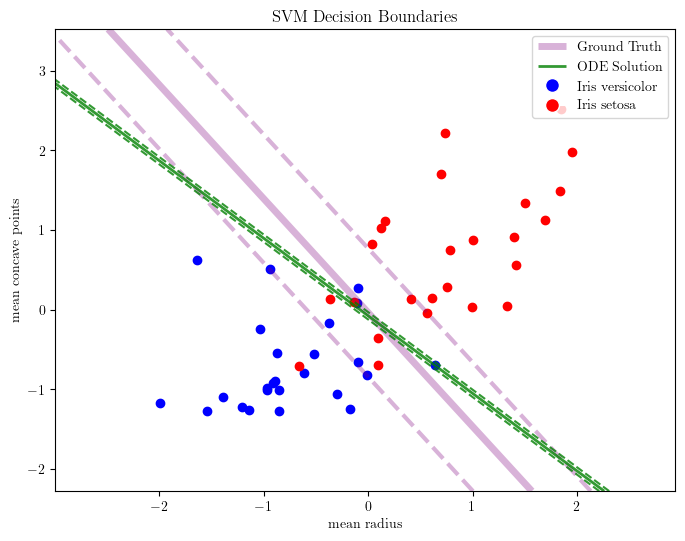

Variables: [ 0.63064456  1.2580895   1.3102977   0.32916373  4.4639463  -0.1274718
  0.9284913   0.34377867  1.5716007   1.2444872   0.37597328  0.6154878
  0.57741934  0.9088185   5.5687165   1.2786496   1.4886796   2.468342
  0.8713288   0.8748145   2.2195864   0.4166981   2.2299538   0.64207983
  0.60872144  1.2672757   0.47593045  1.1587628   3.826883    1.6592771
  0.2247845   1.0735421   0.785522    0.9003257   0.5687288   0.40969068
  2.9894962   0.6864815   0.2131933   0.58155286  0.6625364   1.9470625
  0.7895372   2.9932454   6.439781    1.1366968   2.372391    0.79076755
  0.6586319   0.29925025]
Constraints: [ -0.63064456  -1.2580895   -1.3102977   -0.32916373  -4.4639463
   0.1274718   -0.9284913   -0.34377867  -1.5716007   -1.2444872
  -0.37597328  -0.6154878   -0.57741934  -0.9088185   -5.5687165
  -1.2786496   -1.4886796   -2.468342    -0.8713288   -0.8748145
  -2.2195864   -0.4166981   -2.2299538   -0.64207983  -0.60872144
  -1.2672757   -0.47593045  -1.1587628   -3.82

In [34]:
net = res['net']
res_ = net(torch.tensor([T]).cuda()).cpu().detach().numpy()

w_pinn, b_pinn, sv_pinn = alpha_to_wb(res_[:nx], selected_X, selected_y)

print(f"Weight vector w: {w_pinn}")
print(f"Bias term b: {b_pinn}")
print(f"Number of support vectors: {np.sum(sv_pinn)}")

plot_svm_decision_boundary_confrontation(selected_X, selected_y, w_ode, b_ode, w_pinn, b_pinn, 0, 1)

print('Variables:', res_[:nx])
print('Constraints:', g(res_[:nx]))